In [89]:
import asyncio
import logging
import os
from typing import List, TypedDict, Annotated, Sequence, Dict, Optional, Union

from dotenv import load_dotenv
import fitz  # PyMuPDF
from langchain_community.vectorstores import FAISS #, VectorStoreRetriever
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain_core.documents import Document
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.language_models import BaseLanguageModel
from langgraph.graph import StateGraph, END



In [12]:
root_directory = "/Users/d3y010/repos/crvernon/knowai"

vectorstore_path = "/Users/d3y010/repos/crvernon/knowai/test_faiss_store"

load_dotenv(os.path.join(root_directory, ".env")) # Load environment variables from .env file

k_chunks_retriever = 25

# Fetch Azure credentials from environment variables
api_key = os.getenv("AZURE_OPENAI_API_KEY", default=None)
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT", default=None)
deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT", "gpt-4o") # Default model
embeddings_deployment = os.getenv("AZURE_EMBEDDINGS_DEPLOYMENT", "text-embedding-3-large") # Default embedding model
openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2024-02-01") # API version

# instantiate logger
logger = logging.getLogger(__name__)


In [83]:


def list_vectorstore_files(vectorstore) -> List[str]:
    """
    Return a sorted list of unique filenames stored in the FAISS vectorstore.

    The filenames are extracted from the ``metadata`` dictionary of each
    document under the key ``"file"``. If the vectorstore is ``None`` or no
    filenames are present, an empty list is returned.

    Parameters
    ----------
    vectorstore : FAISS | None
        The FAISS vectorstore instance from which to extract filenames.

    Returns
    -------
    List[str]
        Alphabetically sorted list of unique filenames found in the metadata.
    """
    if vectorstore is None:
        logging.error("Cannot list files: vectorstore is None")
        return []

    files = set()
    # Access the underlying docstore dictionary
    try:
        for _, doc in vectorstore.docstore._dict.items():
            filename = doc.metadata.get("file")
            if filename:
                files.add(filename)
    except Exception:
        logging.exception("Failed to access docstore when listing files")
        return []

    file_list = sorted(files)
    logging.info("Files in vectorstore: %s", file_list)
    return file_list


def pdf_to_chunks(
    file_path: str,
    chunk_size: int = 1500,
    chunk_overlap: int = 300,
) -> List[Document]:
    """
    Load a single PDF file and split its pages into overlapping text chunks.

    Each chunk is returned as a ``Document`` whose ``metadata`` dictionary
    contains:
        {"file": "<pdf-filename>", "page": <page-number>}

    Parameters
    ----------
    file_path : str
        Path to the PDF file.
    chunk_size : int, default 1500
        Maximum characters per chunk.
    chunk_overlap : int, default 300
        Number of characters overlapped between adjacent chunks.

    Returns
    -------
    List[Document]
        ``Document`` objects ready for vectorstore ingestion.
    """
    if not os.path.exists(file_path):
        logging.error("PDF file does not exist: %s", file_path)
        return []

    filename = os.path.basename(file_path)
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
    )

    chunks: List[Document] = []
    try:
        pdf = fitz.open(file_path)
    except Exception:
        logging.exception("Failed to open PDF: %s", file_path)
        return []

    for page_num in range(len(pdf)):
        try:
            text = pdf.load_page(page_num).get_text()
        except Exception:
            logging.exception("Failed to read page %d of %s", page_num + 1, filename)
            continue

        if not text:
            continue

        for piece in splitter.split_text(text):
            chunks.append(
                Document(
                    page_content=piece,
                    metadata={"file": filename, "page": page_num + 1},
                )
            )

    pdf.close()
    logging.info("Extracted %d chunks from %s", len(chunks), filename)
    return chunks


def add_new_pdfs_to_vectorstore(
    directory_path: str,
    vectorstore: FAISS,
    chunk_size: int = 1500,
    chunk_overlap: int = 300,
) -> int:
    """
    Scan a directory for PDF files that are not yet present in the given
    vectorstore and add their text chunks to the store.

    A PDF is considered *already present* if its filename appears in the
    ``"file"`` metadata of any existing document in the vectorstore.

    Parameters
    ----------
    directory_path : str
        Directory containing one or more ``.pdf`` files.
    vectorstore : FAISS
        An *already instantiated* FAISS vectorstore to update.
    chunk_size : int, default 1500
        Maximum characters per chunk when splitting text.
    chunk_overlap : int, default 300
        Number of characters overlapped between consecutive chunks.

    Returns
    -------
    int
        Total number of **new chunks** added to the vectorstore.
    """
    if vectorstore is None:
        logging.error("Vectorstore is None; cannot add new PDFs.")
        return 0

    if not os.path.isdir(directory_path):
        logging.error("Provided directory does not exist: %s", directory_path)
        return 0

    # Collect filenames already indexed
    existing_files = set()
    for _, doc in vectorstore.docstore._dict.items():
        filename = doc.metadata.get("file")
        if filename:
            existing_files.add(filename)

    new_docs: List[Document] = []
    pdf_files = sorted(
        f for f in os.listdir(directory_path) if f.lower().endswith(".pdf")
    )

    for filename in pdf_files:
        if filename in existing_files:
            logging.debug("Skipping %s (already indexed).", filename)
            continue

        file_path = os.path.join(directory_path, filename)
        docs = pdf_to_chunks(
            file_path=file_path,
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
        )
        new_docs.extend(docs)

    if not new_docs:
        logging.info("No new PDFs found in %s.", directory_path)
        return 0

    vectorstore.add_documents(new_docs)
    logging.info(
        "Added %d chunks from %d new PDF(s) to vectorstore.",
        len(new_docs),
        len({d.metadata['file'] for d in new_docs}),
    )
    return len(new_docs)


def instantiate_retriever(
    vectorstore: FAISS,
    allowed_files: Optional[List[str]] = None,
    top_n_similar: int = 25,
):
    """
    Instantiate a retriever from an existing FAISS vectorstore.

    Parameters
    ----------
    vectorstore : FAISS
        The FAISS vectorstore that already contains your document embeddings.
    allowed_files : list[str] | None, optional
        Filenames to restrict retrieval to. When ``None`` or an empty list,
        the retriever searches across **all** chunks in the store.
    top_n_similar : int, default 25
        Number of most‑similar chunks to return.

    Returns
    -------
    VectorStoreRetriever
        A LangChain retriever configured with the specified constraints.

    Raises
    ------
    ValueError
        If *vectorstore* is ``None``.
    """
    if vectorstore is None:
        raise ValueError("`vectorstore` must be a valid FAISS instance.")

    # Base kwargs
    search_kwargs = {"k": top_n_similar}

    # Add metadata filter only when filenames are supplied
    if allowed_files:
        search_kwargs["filter"] = {"file": {"$in": allowed_files}}

    return vectorstore.as_retriever(search_kwargs=search_kwargs)


def extract_using_multiquery(
    question: str,
    llm: "BaseLanguageModel",
    retriever: "VectorStoreRetriever",
    n_alternatives: int = 4,
    k_per_query: int = 25,
) -> List["Document"]:
    """
    Generate alternative phrasings of *question* (via ``MultiQueryRetriever``'s components)
    **and** return the unique chunks retrieved from the provided *retriever*.

    The function workflow is:

    1. Use the ``llm_chain`` from ``MultiQueryRetriever`` to generate a text containing
       multiple query formulations.
    2. Parse this text (typically newline-separated queries) into a list of queries.
    3. For each generated query (plus the original), run
       ``retriever.get_relevant_documents`` (with *k_per_query*).
    4. Merge all returned `Document`s, deduplicate them
       (file‑name + page‑number + content), and return the unique list.

    Parameters
    ----------
    question : str
        The original user question.
    llm : BaseLanguageModel
        The LLM used by ``MultiQueryRetriever`` to craft alternative queries.
    retriever : VectorStoreRetriever
        A retriever tied to the target vectorstore.
    n_alternatives : int, default 4
        Number of alternative queries to generate.
    k_per_query : int, default 25
        Top‑*k* chunks to retrieve per query.

    Returns
    -------
    List[Document]
        Unique chunks drawn from the vectorstore across **all** generated
        queries (including the original question).

    Notes
    -----
    * The function silently falls back to returning chunks for just the
      original question if alternative query generation fails.
    * Deduplication key: ``(file, page, page_content)``.
    """

    # Initialize MultiQueryRetriever to access its llm_chain
    # Note: Ensure the MultiQueryRetriever import path is correct for your Langchain version.
    mqr = MultiQueryRetriever.from_llm(retriever=retriever, llm=llm)

    alt_queries: List[str] = []
    try:
        # Directly use the llm_chain from MultiQueryRetriever to generate queries.
        # The input to the llm_chain is typically a dict with the key "question".
        chain_input = {"question": question}
        # Invoke the chain; it will use default callback handling.
        llm_response = mqr.llm_chain.invoke(chain_input)

        raw_queries_text = ""
        # Process the llm_response to get a single string of newline-separated queries.
        if isinstance(llm_response, dict):
            # Default output key for LLMChain is 'text'.
            # MultiQueryRetriever's llm_chain is an LLMChain.
            raw_queries_text = llm_response.get(mqr.llm_chain.output_key, "")
            logging.debug(f"LLMChain response was a dict. Raw text: '{raw_queries_text[:100]}...'")
        elif isinstance(llm_response, list):
            logging.debug(
                f"LLMChain response was a list. Attempting to process as list of query strings. Content: {llm_response}"
            )
            # If the LLM directly returns a list of query strings
            if all(isinstance(item, str) for item in llm_response):
                raw_queries_text = "\n".join(llm_response) # Join them into a single string
                logging.debug(f"Joined list of strings into: '{raw_queries_text[:100]}...'")
            else:
                logging.warning(
                    "LLMChain response was a list, but not all items are strings. Cannot process."
                )
        elif isinstance(llm_response, str):
            logging.debug(
                f"LLMChain response was a string directly. Processing as raw text. Response: {llm_response[:100]}..."
            )
            raw_queries_text = llm_response
        else:
            logging.warning(
                f"Unexpected response type from llm_chain.invoke: {type(llm_response)}. Expected dict, list, or str."
            )

        if raw_queries_text:
            # The default prompt for MultiQueryRetriever asks for newline-separated queries.
            # Split the raw text by newlines and filter out any empty strings.
            alt_queries = [q.strip() for q in raw_queries_text.split("\n") if q.strip()]
            logging.debug(f"Parsed queries from raw text: {alt_queries}")
        else:
            logging.warning("No raw query text obtained or processed from LLM chain response for multi-query.")
            alt_queries = []

    except Exception:
        logging.exception(
            "Failed to generate or parse alternative queries using mqr.llm_chain.invoke"
        )
        alt_queries = [] # Ensure alt_queries is defined and empty on failure

    # Clean & truncate to desired count (duplicates are already handled by list(dict.fromkeys(...)))
    # Remove empty strings (already done by strip() and check in list comprehension)
    # and duplicates, then truncate.
    alt_queries = list(dict.fromkeys(alt_queries)) # Remove duplicates while preserving order
    alt_queries = alt_queries[:n_alternatives]

    # Always include the original question for retrieval
    query_list = [question] + alt_queries

    logging.info(f"Running retrieval for {len(query_list)} queries: {query_list}")

    # Retrieve docs for each query
    retrieved_docs: List["Document"] = []
    for q_text in query_list:
        try:
            # Attempt to use 'k' parameter
            docs_for_query = retriever.get_relevant_documents(q_text, k=k_per_query)
        except TypeError as e:
            # Check if TypeError is due to unexpected 'k' argument
            if 'unexpected keyword argument \'k\'' in str(e).lower() or \
               'got an unexpected keyword argument \'k\'' in str(e).lower():
                logging.debug(f"Retriever for query '{q_text[:50]}...' does not support 'k' arg, retrieving all and slicing.")
                docs_for_query = retriever.get_relevant_documents(q_text)
                docs_for_query = docs_for_query[:k_per_query] # Manual slicing
            else:
                # Different TypeError, log and skip this query's docs
                logging.exception(f"TypeError during retrieval for query: '{q_text[:50]}...'")
                continue
        except Exception:
            logging.exception(f"Retrieval failed for query: '{q_text[:50]}...'")
            continue # Skip this query's docs if any other exception occurs
        retrieved_docs.extend(docs_for_query)

    # Deduplicate documents
    # Using a dictionary to store unique documents based on a key
    unique_docs_map: Dict[tuple, "Document"] = {}
    for doc in retrieved_docs:
        # Create a unique key for each document.
        # Ensure page_content is stripped for consistent keying.
        # Handle cases where metadata might be missing 'file' or 'page'.
        doc_file = doc.metadata.get("file") if hasattr(doc, 'metadata') and doc.metadata else None
        doc_page = doc.metadata.get("page") if hasattr(doc, 'metadata') and doc.metadata else None
        key = (
            doc_file,
            doc_page,
            doc.page_content.strip() if hasattr(doc, 'page_content') else "",
        )
        if key not in unique_docs_map:
            unique_docs_map[key] = doc

    final_unique_docs = list(unique_docs_map.values())
    logging.info(f"Retrieved {len(retrieved_docs)} chunks -> {len(final_unique_docs)} unique after dedup.")

    return final_unique_docs


In [44]:
# load embeddings model
embeddings = AzureOpenAIEmbeddings(
    azure_deployment=embeddings_deployment,
    azure_endpoint=azure_endpoint,
    api_key=api_key,
    openai_api_version=openai_api_version
)

# load existing vectorstore
vectorstore = load_faiss_vectorstore(
    path=vectorstore_path, 
    embeddings=embeddings
)


In [45]:
# list the files currently in the vectorstore
files_in_vectorstore = list_vectorstore_files(vectorstore)

files_in_vectorstore


['ID_OR_Idaho_Power_2022.pdf', 'OR_City_of_Bandon_2024.pdf']

In [46]:
# load new files from a directory
pass


In [63]:
# instantiate a retriever
retriever = instantiate_retriever(
    vectorstore=vectorstore,
    allowed_files=["OR_City_of_Bandon_2024.pdf"],
    top_n_similar=5
)


In [64]:
question = "What does types of vegetation management are mentioned in this report?"

# retriever.invoke(question)


In [65]:
llm = AzureChatOpenAI(
    temperature=0.3, 
    api_key=api_key, 
    openai_api_version=openai_api_version,
    azure_deployment=deployment,
    azure_endpoint=azure_endpoint,
)


In [66]:
docs = extract_using_multiquery(
    question=question,
    llm=llm,
    retriever=retriever,
    n_alternatives=4,
    k_per_query=10,
)


In [67]:
len(docs)

5

## Implement Graph

In [139]:
class GraphState(TypedDict):

    embeddings: Union[None, AzureOpenAIEmbeddings]
    vectorstore_path: str
    vectorstore: Union[None, FAISS]
    llm_large: Union[None, AzureChatOpenAI]
    allowed_files: Union[None, List[str]]
    question: str
    documents: List[Document]
    individual_answers: Dict[str, str]


def instantiate_embeddings(state: GraphState):

    # Retrieve current embeddings instantiation state
    embeddings = state.get("embeddings", None) 

    if embeddings:
        logging.info("Using pre-instantiated embeddings model")
        return state
    
    else:
        logging.info("Instantiating embeddings model")
        return {
            **state, 
            "embeddings": AzureOpenAIEmbeddings(
                azure_deployment=embeddings_deployment,
                azure_endpoint=azure_endpoint,
                api_key=api_key,
                openai_api_version=openai_api_version
            )
        }


def instantiate_llm_large(state: GraphState):

    # Retrieve current LLM instantiation state
    llm_large = state.get("llm_large", None) 

    if llm_large:
        logging.info("Using pre-instantiated large LLM model")
        return state
    
    else:
        logging.info("Instantiating large LLM model")
        return {
            **state, 
            "llm_large": AzureChatOpenAI(
                temperature=0, 
                api_key=api_key, 
                openai_api_version=openai_api_version,
                azure_deployment=deployment,
                azure_endpoint=azure_endpoint,
            )
        }


def instantiate_retriever(state: GraphState, top_n_similar: int = 25):
    """
    Instantiate a retriever from an existing FAISS vectorstore.

    Parameters
    ----------
    vectorstore : FAISS
        The FAISS vectorstore that already contains your document embeddings.
    allowed_files : list[str] | None, optional
        Filenames to restrict retrieval to. When ``None`` or an empty list,
        the retriever searches across **all** chunks in the store.
    top_n_similar : int, default 25
        Number of most‑similar chunks to return.

    Returns
    -------
    VectorStoreRetriever
        A LangChain retriever configured with the specified constraints.

    Raises
    ------
    ValueError
        If *vectorstore* is ``None``.
    """
    vectorstore = state.get("vectorstore", None)
    allowed_files = state.get("allowed_files", None)
    
    if vectorstore is None:
        raise ValueError("`vectorstore` must be a valid FAISS instance.")

    # Base kwargs
    search_kwargs = {"k": top_n_similar}

    # Add metadata filter only when filenames are supplied
    if allowed_files:
        search_kwargs["filter"] = {"file": {"$in": allowed_files}}

    return vectorstore.as_retriever(search_kwargs=search_kwargs)

    return {
        **state, 
        "retriever": vectorstore.as_retriever(search_kwargs=search_kwargs)
    }


def load_faiss_vectorstore(state: GraphState) -> GraphState:
    """
    Load a FAISS vectorstore that was previously saved to disk.
    Updates the 'vectorstore' field in the state.

    Parameters
    ----------
    state : GraphState
        The current state of the graph, containing 'vectorstore_path' and 'embeddings'.

    Returns
    -------
    GraphState
        The updated state. If loading fails, 'vectorstore' in the state will be None.
    """
    # Retrieve state variables
    current_vectorstore_path = state.get("vectorstore_path")
    # The 'vectorstore' from the state is the one we might be replacing or confirming.
    # No need to get it here as we are deciding whether to load a new one.
    embeddings = state.get("embeddings") 

    # Check if vectorstore is already loaded in a previous step (though this node is usually for loading)
    if state.get("vectorstore"):
        logging.info("Vectorstore already exists in state. Skipping loading.")
        return state # Return the current state as is

    if not current_vectorstore_path:
        logging.error("Vectorstore path is not provided in the state.")
        return {**state, "vectorstore": None} # Update state and return

    if not os.path.exists(current_vectorstore_path):
        logging.error("FAISS vectorstore path does not exist: %s", current_vectorstore_path)
        return {**state, "vectorstore": None} # Update state and return

    if not os.path.isdir(current_vectorstore_path):
        logging.error("Provided FAISS vectorstore path is not a directory: %s", current_vectorstore_path)
        return {**state, "vectorstore": None} # Update state and return
    
    if embeddings is None:
        logging.error("Embeddings not yet instantiated. Review workflow to ensure 'instantiate_embeddings' node runs before this.")
        return {**state, "vectorstore": None} # Update state and return
    
    try:
        logging.info("Loading FAISS vectorstore from '%s' ...", current_vectorstore_path)
        loaded_vectorstore = FAISS.load_local(
            folder_path=current_vectorstore_path, # Parameter name is folder_path
            embeddings=embeddings,
            allow_dangerous_deserialization=True
        )
        logging.info("FAISS vectorstore loaded with %d embeddings.", loaded_vectorstore.index.ntotal)
        return {**state, "vectorstore": loaded_vectorstore} # Update state with loaded vectorstore
        
    except Exception as e: # Catching specific exception is better if known
        logging.exception("Failed to load FAISS vectorstore from '%s': %s", current_vectorstore_path, e)
        return {**state, "vectorstore": None} # Update state, vectorstore is None


def extract_using_multiquery(state: GraphState) -> List["Document"]:
    """
    Generate alternative phrasings of *question* (via ``MultiQueryRetriever``'s components)
    **and** return the unique chunks retrieved from the provided *retriever*.

    The function workflow is:

    1. Use the ``llm_chain`` from ``MultiQueryRetriever`` to generate a text containing
       multiple query formulations.
    2. Parse this text (typically newline-separated queries) into a list of queries.
    3. For each generated query (plus the original), run
       ``retriever.get_relevant_documents`` (with *k_per_query*).
    4. Merge all returned `Document`s, deduplicate them
       (file‑name + page‑number + content), and return the unique list.

    Parameters
    ----------
    question : str
        The original user question.
    llm : BaseLanguageModel
        The LLM used by ``MultiQueryRetriever`` to craft alternative queries.
    retriever : VectorStoreRetriever
        A retriever tied to the target vectorstore.
    n_alternatives : int, default 4
        Number of alternative queries to generate.
    k_per_query : int, default 25
        Top‑*k* chunks to retrieve per query.

    Returns
    -------
    List[Document]
        Unique chunks drawn from the vectorstore across **all** generated
        queries (including the original question).

    Notes
    -----
    * The function silently falls back to returning chunks for just the
      original question if alternative query generation fails.
    * Deduplication key: ``(file, page, page_content)``.
    """
    question = state.get("question", None)
    llm = state.get("llm_large", None)
    retriever = state.get("retriever", None)
    n_alternatives = state.get("n_alternatives", 4)
    k_per_query = state.get("k_per_query", 25)


    # Initialize MultiQueryRetriever to access its llm_chain
    # Note: Ensure the MultiQueryRetriever import path is correct for your Langchain version.
    mqr = MultiQueryRetriever.from_llm(retriever=retriever, llm=llm)

    alt_queries: List[str] = []
    try:
        # Directly use the llm_chain from MultiQueryRetriever to generate queries.
        # The input to the llm_chain is typically a dict with the key "question".
        chain_input = {"question": question}
        # Invoke the chain; it will use default callback handling.
        llm_response = mqr.llm_chain.invoke(chain_input)

        raw_queries_text = ""
        # Process the llm_response to get a single string of newline-separated queries.
        if isinstance(llm_response, dict):
            # Default output key for LLMChain is 'text'.
            # MultiQueryRetriever's llm_chain is an LLMChain.
            raw_queries_text = llm_response.get(mqr.llm_chain.output_key, "")
            logging.debug(f"LLMChain response was a dict. Raw text: '{raw_queries_text[:100]}...'")
        elif isinstance(llm_response, list):
            logging.debug(
                f"LLMChain response was a list. Attempting to process as list of query strings. Content: {llm_response}"
            )
            # If the LLM directly returns a list of query strings
            if all(isinstance(item, str) for item in llm_response):
                raw_queries_text = "\n".join(llm_response) # Join them into a single string
                logging.debug(f"Joined list of strings into: '{raw_queries_text[:100]}...'")
            else:
                logging.warning(
                    "LLMChain response was a list, but not all items are strings. Cannot process."
                )
        elif isinstance(llm_response, str):
            logging.debug(
                f"LLMChain response was a string directly. Processing as raw text. Response: {llm_response[:100]}..."
            )
            raw_queries_text = llm_response
        else:
            logging.warning(
                f"Unexpected response type from llm_chain.invoke: {type(llm_response)}. Expected dict, list, or str."
            )

        if raw_queries_text:
            # The default prompt for MultiQueryRetriever asks for newline-separated queries.
            # Split the raw text by newlines and filter out any empty strings.
            alt_queries = [q.strip() for q in raw_queries_text.split("\n") if q.strip()]
            logging.debug(f"Parsed queries from raw text: {alt_queries}")
        else:
            logging.warning("No raw query text obtained or processed from LLM chain response for multi-query.")
            alt_queries = []

    except Exception:
        logging.exception(
            "Failed to generate or parse alternative queries using mqr.llm_chain.invoke"
        )
        alt_queries = [] # Ensure alt_queries is defined and empty on failure

    # Clean & truncate to desired count (duplicates are already handled by list(dict.fromkeys(...)))
    # Remove empty strings (already done by strip() and check in list comprehension)
    # and duplicates, then truncate.
    alt_queries = list(dict.fromkeys(alt_queries)) # Remove duplicates while preserving order
    alt_queries = alt_queries[:n_alternatives]

    # Always include the original question for retrieval
    query_list = [question] + alt_queries

    logging.info(f"Running retrieval for {len(query_list)} queries: {query_list}")

    # Retrieve docs for each query
    retrieved_docs: List["Document"] = []
    for q_text in query_list:
        try:
            # Attempt to use 'k' parameter
            docs_for_query = retriever.get_relevant_documents(q_text, k=k_per_query)
        except TypeError as e:
            # Check if TypeError is due to unexpected 'k' argument
            if 'unexpected keyword argument \'k\'' in str(e).lower() or \
               'got an unexpected keyword argument \'k\'' in str(e).lower():
                logging.debug(f"Retriever for query '{q_text[:50]}...' does not support 'k' arg, retrieving all and slicing.")
                docs_for_query = retriever.get_relevant_documents(q_text)
                docs_for_query = docs_for_query[:k_per_query] # Manual slicing
            else:
                # Different TypeError, log and skip this query's docs
                logging.exception(f"TypeError during retrieval for query: '{q_text[:50]}...'")
                continue
        except Exception:
            logging.exception(f"Retrieval failed for query: '{q_text[:50]}...'")
            continue # Skip this query's docs if any other exception occurs
        retrieved_docs.extend(docs_for_query)

    # Deduplicate documents
    # Using a dictionary to store unique documents based on a key
    unique_docs_map: Dict[tuple, "Document"] = {}
    for doc in retrieved_docs:
        # Create a unique key for each document.
        # Ensure page_content is stripped for consistent keying.
        # Handle cases where metadata might be missing 'file' or 'page'.
        doc_file = doc.metadata.get("file") if hasattr(doc, 'metadata') and doc.metadata else None
        doc_page = doc.metadata.get("page") if hasattr(doc, 'metadata') and doc.metadata else None
        key = (
            doc_file,
            doc_page,
            doc.page_content.strip() if hasattr(doc, 'page_content') else "",
        )
        if key not in unique_docs_map:
            unique_docs_map[key] = doc

    final_unique_docs = list(unique_docs_map.values())
    logging.info(f"Retrieved {len(retrieved_docs)} chunks -> {len(final_unique_docs)} unique after dedup.")

    return final_unique_docs


In [144]:
async def _async_extract_for_single_file(
    question: str, 
    llm: BaseLanguageModel, 
    retriever: "VectorStoreRetriever", # File-specific retriever
    file_name: str, 
    n_alternatives: int, 
    k_per_query: int
) -> tuple[str, Optional[List[Document]]]:
    """
    Async helper to extract documents for a single file using MultiQueryRetriever.
    """
    logging.info(f"Starting extraction for file: {file_name} with question: \"{question[:50]}...\"")
    try:
        # Ensure retriever is file-specific by checking its search_kwargs if possible
        # This function assumes the passed retriever is already correctly filtered for the file_name
        
        mqr = MultiQueryRetriever.from_llm(retriever=retriever, llm=llm)
        alt_queries: List[str] = []
        
        chain_input = {"question": question}
        llm_response = await mqr.llm_chain.ainvoke(chain_input) 
        
        raw_queries_text = ""
        if isinstance(llm_response, dict):
            raw_queries_text = llm_response.get(mqr.llm_chain.output_key, "")
        elif isinstance(llm_response, str):
            raw_queries_text = llm_response
        else:
            logging.warning(f"[{file_name}] Unexpected LLM response type: {type(llm_response)}. Trying to parse as string.")
            raw_queries_text = str(llm_response)

        if raw_queries_text:
            alt_queries = [q.strip() for q in raw_queries_text.split("\n") if q.strip()]
        else:
            logging.warning(f"[{file_name}] No raw query text obtained from LLM chain response.")
            alt_queries = []

        alt_queries = list(dict.fromkeys(alt_queries))[:n_alternatives]
        query_list = [question] + alt_queries
        logging.debug(f"[{file_name}] Running retrieval for {len(query_list)} queries: {query_list}")

        retrieved_docs: List[Document] = []
        for q_text in query_list:
            try:
                docs_for_query = await retriever.ainvoke(q_text, k=k_per_query)
                retrieved_docs.extend(docs_for_query)
            except Exception as e_retrieve:
                logging.exception(f"[{file_name}] Retrieval failed for query: '{q_text[:50]}...': {e_retrieve}")
                continue
        
        unique_docs_map: Dict[tuple, Document] = {}
        for doc in retrieved_docs:
            doc_file_meta = doc.metadata.get("file") if hasattr(doc, 'metadata') and doc.metadata else None
            doc_page_meta = doc.metadata.get("page") if hasattr(doc, 'metadata') and doc.metadata else None
            key = (
                doc_file_meta, 
                doc_page_meta,
                doc.page_content.strip() if hasattr(doc, 'page_content') else "",
            )
            if key not in unique_docs_map:
                unique_docs_map[key] = doc
        
        final_unique_docs = list(unique_docs_map.values())
        logging.info(f"[{file_name}] Retrieved {len(retrieved_docs)} docs -> {len(final_unique_docs)} unique docs.")
        return file_name, final_unique_docs

    except Exception as e_outer:
        logging.exception(f"[{file_name}] Critical error during document extraction for file: {e_outer}")
        return file_name, None


async def extract_documents_parallel_node(state: GraphState) -> GraphState:
    """
    Node to extract documents in parallel for each allowed file using multi-query.
    Results are stored in state["documents_by_file"].
    """
    question = state.get("question")
    llm = state.get("llm_large")
    base_retriever = state.get("retriever") 
    vectorstore = state.get("vectorstore") 
    allowed_files = state.get("allowed_files", [])
    
    n_alternatives = state.get("n_alternatives") if state.get("n_alternatives") is not None else 4
    k_per_query = state.get("k_per_query") if state.get("k_per_query") is not None else k_chunks_retriever

    # Critical checks for linear flow; if any of these are None, something went wrong earlier.
    if not question:
        logging.error("Question is missing from state. Cannot extract documents.")
        return {**state, "documents_by_file": {}}
    if not llm:
        logging.error("LLM is missing from state. Cannot extract documents.")
        return {**state, "documents_by_file": {}}
    if not base_retriever: # Base retriever should be instantiated by now
        logging.error("Base retriever is missing from state. Cannot extract documents.")
        return {**state, "documents_by_file": {}}
    if not vectorstore: # Vectorstore should be loaded by now
        logging.error("Vectorstore is missing from state. Cannot create file-specific retrievers.")
        return {**state, "documents_by_file": {}}
    if not allowed_files:
        logging.warning("No allowed_files specified. Skipping document extraction.")
        return {**state, "documents_by_file": {}}


    tasks = []
    for file_name in allowed_files:
        file_specific_search_kwargs = {**(base_retriever.search_kwargs if base_retriever.search_kwargs else {}), 
                                       "filter": {"file": file_name}}
        
        try:
            file_specific_retriever = vectorstore.as_retriever(search_kwargs=file_specific_search_kwargs)
            logging.debug(f"Created file-specific retriever for '{file_name}' with kwargs: {file_specific_search_kwargs}")
        except Exception as e_ret_create:
            logging.error(f"Failed to create file-specific retriever for {file_name}: {e_ret_create}. Skipping this file.")
            continue

        tasks.append(
            _async_extract_for_single_file(
                question=question,
                llm=llm,
                retriever=file_specific_retriever,
                file_name=file_name,
                n_alternatives=n_alternatives,
                k_per_query=k_per_query
            )
        )
    
    if not tasks:
        logging.warning("No tasks created for parallel extraction (e.g., issues creating retrievers for all allowed_files).")
        return {**state, "documents_by_file": {}}

    logging.info(f"Gathering results for {len(tasks)} files asynchronously...")
    results_with_filenames = await asyncio.gather(*tasks)

    documents_by_file_result: Dict[str, List[Document]] = {}
    for f_name, docs in results_with_filenames:
        if docs is not None:
            documents_by_file_result[f_name] = docs
            logging.info(f"Successfully processed and stored {len(docs)} documents for file: {f_name}")
        else:
            documents_by_file_result[f_name] = [] 
            logging.warning(f"Processing failed for file: {f_name}. Storing empty list.")

    return {**state, "documents_by_file": documents_by_file_result}


# Initialize the StateGraph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("instantiate_embeddings_node", instantiate_embeddings)
workflow.add_node("instantiate_llm_node", instantiate_llm_large)
workflow.add_node("load_vectorstore_node", load_faiss_vectorstore)
workflow.add_node("instantiate_retriever_node", instantiate_retriever)
workflow.add_node("extract_documents_node", extract_documents_parallel_node)

# Define the graph's flow (edges) - Linear sequence
workflow.set_entry_point("instantiate_embeddings_node")
workflow.add_edge("instantiate_embeddings_node", "instantiate_llm_node")
workflow.add_edge("instantiate_llm_node", "load_vectorstore_node")
workflow.add_edge("load_vectorstore_node", "instantiate_retriever_node")
workflow.add_edge("instantiate_retriever_node", "extract_documents_node")
workflow.add_edge("extract_documents_node", END) # After extraction, the process ends

# Compile the graph
app = workflow.compile()

# Define the initial state for the graph invocation
initial_state: GraphState = {
    "embeddings": None,
    "vectorstore_path": vectorstore_path, 
    "vectorstore": None,
    "llm_large": None,
    "retriever": None,
    "allowed_files": ['ID_OR_Idaho_Power_2022.pdf', 'OR_City_of_Bandon_2024.pdf'], # Example files
    "question": "What are the current practices for vegetation management?", 
    "documents_by_file": None, 
    "individual_answers": None,
    "n_alternatives": 4,       
    "k_per_query": 10          
}

async def main():
    """
    Main async function to run the graph.
    """
    if not all([api_key, azure_endpoint]):
        logging.error("Azure OpenAI credentials not found. Halting.")
        return

    logging.info("Starting asynchronous graph invocation with linear flow...")
    final_state = await app.ainvoke(initial_state)
    
    logging.info("Graph invocation completed.")
    logging.info("Final state overview:")
    logging.info(f"  Embeddings loaded: {True if final_state.get('embeddings') else False}")
    logging.info(f"  LLM loaded: {True if final_state.get('llm_large') else False}")
    logging.info(f"  Vectorstore loaded: {True if final_state.get('vectorstore') else False}")
    if final_state.get('vectorstore'):
        logging.info(f"    Vectorstore contains {final_state['vectorstore'].index.ntotal} embeddings.")
    logging.info(f"  Retriever instantiated: {True if final_state.get('retriever') else False}")
    
    docs_by_file = final_state.get("documents_by_file")
    if docs_by_file:
        logging.info("  Documents extracted by file:")
        for file_name, docs_list in docs_by_file.items():
            logging.info(f"    {file_name}: {len(docs_list)} documents")
    else:
        logging.info("  No documents were extracted or extraction failed.")

if __name__ == "__main__":
    if not os.path.exists(os.path.join(root_directory, ".env")):
        logging.warning(f".env file not found at {os.path.join(root_directory, '.env')}. Azure credentials might be missing.")
    
    asyncio.run(main())


RuntimeError: asyncio.run() cannot be called from a running event loop

In [140]:
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("instantiate_embeddings", instantiate_embeddings)
workflow.add_node("instantiate_llm_large", instantiate_llm_large)
workflow.add_node("load_vectorstore", load_faiss_vectorstore)
workflow.add_node("instantiate_retriever", instantiate_retriever)

# Define the graph's flow (edges)
workflow.set_entry_point("instantiate_embeddings")
workflow.set_entry_point("instantiate_llm_large")

workflow.add_edge("instantiate_embeddings", "load_vectorstore")
workflow.add_edge("load_vectorstore", "instantiate_retriever") 

workflow.add_edge("load_vectorstore", END)

graph = workflow.compile()


In [141]:
# Define the initial state for the graph invocation
initial_state: GraphState = {
    "embeddings": None,
    "vectorstore_path": vectorstore_path, 
    "vectorstore": None,
    "llm_large": None,
    "allowed_files": None,
    "question": None, 
    "documents": None,
    "individual_answers": None
}


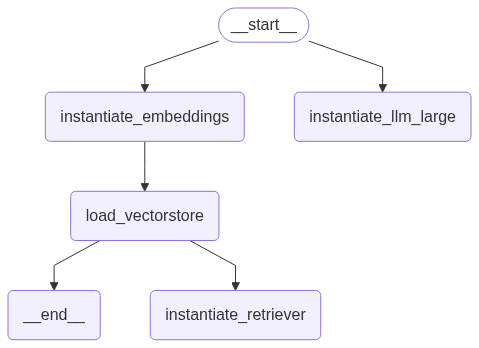

In [142]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))
    

In [128]:
# final_state = asyncio.run(app.ainvoke(initial_state))

final_state = graph.invoke(initial_state)



In [129]:
final_state.get("vectorstore")

## asyncio implementation

In [51]:
import asyncio
import logging
import os
import time 
from typing import List, TypedDict, Annotated, Sequence, Dict, Optional, Union
from collections import deque # For managing conversation history

from dotenv import load_dotenv
import fitz  # PyMuPDF
from langchain_community.vectorstores import FAISS
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain_core.documents import Document
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.language_models import BaseLanguageModel
from langchain_core.vectorstores import VectorStoreRetriever 
from langchain_core.embeddings import Embeddings as LangchainEmbeddings
from langchain_core.prompts import PromptTemplate 
from langchain_core.output_parsers import StrOutputParser 
from langgraph.graph import StateGraph, END


root_directory = "/Users/d3y010/repos/crvernon/knowai"
vectorstore_path = "/Users/d3y010/repos/crvernon/knowai/test_faiss_store"

load_dotenv(os.path.join(root_directory, ".env")) 

k_chunks_retriever = 25 
COMBINE_THRESHOLD = 3 # Max answers/document sets to combine directly; above this, use 2-stage.
MAX_CONVERSATION_TURNS = 10 

api_key = os.getenv("AZURE_OPENAI_API_KEY", default=None)
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT", default=None)
deployment = os.getenv("AZURE_OPENAI_DEPLOYMENT", "gpt-4o") 
embeddings_deployment = os.getenv("AZURE_EMBEDDINGS_DEPLOYMENT", "text-embedding-3-large")
openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2024-02-01")

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class GraphState(TypedDict):
    embeddings: Union[None, LangchainEmbeddings] 
    vectorstore_path: str
    vectorstore: Union[None, FAISS]
    llm_large: Union[None, AzureChatOpenAI] 
    retriever: Union[None, VectorStoreRetriever] 
    allowed_files: Optional[List[str]] 
    question: Optional[str] 
    documents_by_file: Optional[Dict[str, List[Document]]] 
    individual_answers: Optional[Dict[str, str]] 
    n_alternatives: Optional[int] 
    k_per_query: Optional[int]
    generation: Optional[str] 
    conversation_history: Optional[List[Dict[str, str]]]
    bypass_individual_generation: Optional[bool] # New flag
    raw_documents_for_synthesis: Optional[str] # New field for formatted raw docs


def instantiate_embeddings(state: GraphState) -> GraphState:
    t_node_start = time.perf_counter()
    node_name = "instantiate_embeddings_node"
    logging.info(f"--- Starting Node: {node_name} ---")
    if not state.get("embeddings"):
        logging.info("Instantiating embeddings model")
        try:
            new_embeddings = AzureOpenAIEmbeddings(
                azure_deployment=embeddings_deployment, azure_endpoint=azure_endpoint,
                api_key=api_key, openai_api_version=openai_api_version
            )
            state = {**state, "embeddings": new_embeddings}
        except Exception as e:
            logging.error(f"Failed to instantiate embeddings model: {e}")
            state = {**state, "embeddings": None}
    else:
        logging.info("Using pre-instantiated embeddings model")
    duration_node = time.perf_counter() - t_node_start
    logging.info(f"--- Node: {node_name} finished in {duration_node:.4f} seconds ---")
    return state

def instantiate_llm_large(state: GraphState) -> GraphState:
    t_node_start = time.perf_counter()
    node_name = "instantiate_llm_node"
    logging.info(f"--- Starting Node: {node_name} (for query generation) ---")
    if not state.get("llm_large"):
        logging.info("Instantiating large LLM model (for query generation)")
        try:
            new_llm = AzureChatOpenAI(
                temperature=0, api_key=api_key, openai_api_version=openai_api_version,
                azure_deployment=deployment, azure_endpoint=azure_endpoint,
            )
            state = {**state, "llm_large": new_llm}
        except Exception as e:
            logging.error(f"Failed to instantiate large LLM model: {e}")
            state = {**state, "llm_large": None}
    else:
        logging.info("Using pre-instantiated large LLM model (for query generation)")
    duration_node = time.perf_counter() - t_node_start
    logging.info(f"--- Node: {node_name} finished in {duration_node:.4f} seconds ---")
    return state

def load_faiss_vectorstore(state: GraphState) -> GraphState:
    t_node_start = time.perf_counter()
    node_name = "load_vectorstore_node"
    logging.info(f"--- Starting Node: {node_name} ---")
    current_vectorstore_path = state.get("vectorstore_path")
    embeddings = state.get("embeddings")
    if "vectorstore" not in state: state["vectorstore"] = None
    if state.get("vectorstore"): logging.info("Vectorstore already exists in state.")
    elif not current_vectorstore_path: logging.error("Vectorstore path not provided."); state["vectorstore"] = None
    elif not embeddings: logging.error("Embeddings not instantiated."); state["vectorstore"] = None
    elif not os.path.exists(current_vectorstore_path) or not os.path.isdir(current_vectorstore_path):
        logging.error(f"FAISS vectorstore path does not exist or is not a directory: {current_vectorstore_path}"); state["vectorstore"] = None
    else:
        try:
            logging.info(f"Loading FAISS vectorstore from '{current_vectorstore_path}' ...")
            loaded_vectorstore = FAISS.load_local(
                folder_path=current_vectorstore_path, embeddings=embeddings, allow_dangerous_deserialization=True
            )
            logging.info(f"FAISS vectorstore loaded with {loaded_vectorstore.index.ntotal} embeddings.")
            state = {**state, "vectorstore": loaded_vectorstore}
        except Exception as e:
            logging.exception(f"Failed to load FAISS vectorstore: {e}"); state["vectorstore"] = None
    duration_node = time.perf_counter() - t_node_start
    logging.info(f"--- Node: {node_name} finished in {duration_node:.4f} seconds ---")
    return state

def instantiate_retriever(state: GraphState) -> GraphState:
    t_node_start = time.perf_counter()
    node_name = "instantiate_retriever_node"
    logging.info(f"--- Starting Node: {node_name} ---")
    if "retriever" not in state: state["retriever"] = None
    vectorstore = state.get("vectorstore")
    if vectorstore is None: logging.error("Vectorstore not loaded."); state["retriever"] = None
    else:
        search_kwargs = {"k": k_chunks_retriever}
        try:
            base_retriever = vectorstore.as_retriever(search_kwargs=search_kwargs)
            logging.info(f"Base retriever instantiated with default k={k_chunks_retriever}.")
            state = {**state, "retriever": base_retriever}
        except Exception as e:
            logging.exception(f"Failed to instantiate base retriever: {e}"); state["retriever"] = None
    duration_node = time.perf_counter() - t_node_start
    logging.info(f"--- Node: {node_name} finished in {duration_node:.4f} seconds ---")
    return state

async def _async_retrieve_docs_with_embeddings_for_file(
    vectorstore: FAISS, file_name: str, query_embeddings_list: List[List[float]],
    query_list_texts: List[str], k_per_query: int
) -> tuple[str, Optional[List[Document]]]:
    logging.info(f"Retrieving for file: {file_name} using {len(query_embeddings_list)} pre-computed query embeddings.")
    retrieved_docs: List[Document] = []
    try:
        for i, query_embedding in enumerate(query_embeddings_list):
            docs_for_embedding = await vectorstore.asimilarity_search_by_vector(
                embedding=query_embedding, k=k_per_query, filter={"file": file_name}
            )
            retrieved_docs.extend(docs_for_embedding)
        unique_docs_map: Dict[tuple, Document] = {}
        for doc in retrieved_docs:
            key = (doc.metadata.get("file"), doc.metadata.get("page"), doc.page_content.strip() if hasattr(doc, 'page_content') else "")
            if key not in unique_docs_map: unique_docs_map[key] = doc
        final_unique_docs = list(unique_docs_map.values())
        logging.info(f"[{file_name}] Retrieved {len(retrieved_docs)} raw -> {len(final_unique_docs)} unique docs.")
        return file_name, final_unique_docs
    except Exception as e_retrieve:
        logging.exception(f"[{file_name}] Error during similarity search by vector: {e_retrieve}")
        return file_name, None

async def extract_documents_parallel_node(state: GraphState) -> GraphState:
    t_node_start = time.perf_counter()
    node_name = "extract_documents_node"
    logging.info(f"--- Starting Node: {node_name} (Async) ---")
    question, llm, base_retriever, vectorstore, embeddings_model, allowed_files = (
        state.get("question"), state.get("llm_large"), state.get("retriever"),
        state.get("vectorstore"), state.get("embeddings"), state.get("allowed_files")
    )
    n_alternatives, k_per_query = state.get("n_alternatives", 4), state.get("k_per_query", k_chunks_retriever)
    current_documents_by_file: Dict[str, List[Document]] = {}

    if not question: logging.info(f"[{node_name}] No question. Skipping extraction."); return {**state, "documents_by_file": current_documents_by_file}
    if not allowed_files: logging.info(f"[{node_name}] No files selected. Skipping extraction."); return {**state, "documents_by_file": current_documents_by_file}
    if not all([llm, base_retriever, vectorstore, embeddings_model]):
        logging.error(f"[{node_name}] Missing components for extraction. Halting."); return {**state, "documents_by_file": current_documents_by_file}

    query_list: List[str] = [question] # Start with the original question
    try:
        logging.info(f"[{node_name}] Generating alternative queries...")
        mqr_llm_chain = MultiQueryRetriever.from_llm(retriever=base_retriever, llm=llm).llm_chain
        llm_response = await mqr_llm_chain.ainvoke({"question": question})
        raw_queries_text = ""
        if isinstance(llm_response, dict): raw_queries_text = str(llm_response.get(mqr_llm_chain.output_key, ""))
        elif isinstance(llm_response, str): raw_queries_text = llm_response
        elif isinstance(llm_response, list): raw_queries_text = "\n".join(str(item).strip() for item in llm_response if isinstance(item, str) and str(item).strip())
        else: raw_queries_text = str(llm_response)
        
        alt_queries = [q.strip() for q in raw_queries_text.split("\n") if q.strip()]
        query_list.extend(list(dict.fromkeys(alt_queries))[:n_alternatives])
        logging.info(f"[{node_name}] Generated {len(query_list)} total unique queries.")
    except Exception as e_query_gen: logging.exception(f"[{node_name}] Failed to generate alt queries: {e_query_gen}")

    query_embeddings_list: List[List[float]] = []
    try:
        logging.info(f"[{node_name}] Embedding {len(query_list)} queries...")
        query_embeddings_list = await embeddings_model.aembed_documents(query_list) # type: ignore
    except Exception as e_embed: logging.exception(f"[{node_name}] Failed to embed queries: {e_embed}"); return {**state, "documents_by_file": current_documents_by_file}
    if not query_embeddings_list or len(query_embeddings_list) != len(query_list):
        logging.error(f"[{node_name}] Query embedding failed/mismatched."); return {**state, "documents_by_file": current_documents_by_file}

    tasks = [
        _async_retrieve_docs_with_embeddings_for_file(
            vectorstore, f_name, query_embeddings_list, query_list, k_per_query # type: ignore
        ) for f_name in allowed_files
    ]
    if tasks:
        results = await asyncio.gather(*tasks)
        for f_name, docs in results: current_documents_by_file[f_name] = docs if docs else []
    duration_node = time.perf_counter() - t_node_start
    logging.info(f"--- Node: {node_name} finished in {duration_node:.4f} seconds ---")
    return {**state, "documents_by_file": current_documents_by_file}

async def generate_individual_answers_node(state: GraphState) -> GraphState:
    t_node_start = time.perf_counter()
    node_name = "generate_answers_node"
    logging.info(f"--- Starting Node: {node_name} (Async) ---")
    
    question = state.get("question")
    documents_by_file = state.get("documents_by_file")
    # Correctly handle None for allowed_files
    _allowed_files = state.get("allowed_files")
    initial_files_for_answers = _allowed_files if _allowed_files is not None else []

    current_individual_answers: Dict[str, str] = {
        filename: f"No relevant information found in '{filename}' for this question." for filename in initial_files_for_answers
    }
    # Ensure 'generation' is preserved or initialized if not present
    current_generation = state.get("generation")
    state_to_return = {**state, "individual_answers": current_individual_answers, "generation": current_generation}


    if not question: 
        logging.info(f"[{node_name}] No question. Skipping individual answer generation.")
    elif not documents_by_file: 
        logging.info(f"[{node_name}] No 'documents_by_file' from previous step. Using default 'no info' messages for allowed files.")
    else:
        logging.info(f"[{node_name}] Attempting to generate answers for files with documents: {list(f for f, d in documents_by_file.items() if d)}")
        prompt_text = """You are an expert assistant. Answer the user's question based ONLY on the provided context from a SINGLE FILE.
Context from File '{filename}' (Chunks from Pages X, Y, Z...):
{context}
Question: {question}
Detailed Answer (with citations like "quote..." ({filename}, Page X)):"""
        prompt_template = PromptTemplate(template=prompt_text, input_variables=["context", "question", "filename"])
        llm = AzureChatOpenAI(temperature=0.1, api_key=api_key, openai_api_version=openai_api_version, azure_deployment="gpt-4o", azure_endpoint=azure_endpoint, max_tokens=2000)
        chain = prompt_template | llm | StrOutputParser()
        
        async def _gen_ans(fname: str, fdocs: List[Document], q: str) -> tuple[str, str]:
            if not fdocs: return fname, f"No relevant documents found in '{fname}' to answer the question."
            # Ensure filename in context string is the actual filename for the prompt
            ctx = "\n\n".join([f"--- Context from Page {d.metadata.get('page', 'N/A')} (File: {fname}) ---\n{d.page_content}" for d in fdocs])
            try: return fname, await chain.ainvoke({"context": ctx, "question": q, "filename": fname})
            except Exception as e: logging.exception(f"Error for {fname}: {e}"); return fname, f"An error occurred while generating the answer for file '{fname}': {e}"
        
        tasks = []
        # Iterate through initial_files_for_answers to ensure we only process allowed files
        # And check if documents_by_file has entries for them
        for fname_allowed in initial_files_for_answers:
            if fname_allowed in documents_by_file and documents_by_file[fname_allowed]:
                tasks.append(_gen_ans(fname_allowed, documents_by_file[fname_allowed], question))
            else:
                # This file was allowed, but no docs were extracted for it or docs_by_file is missing it.
                # The default message in current_individual_answers for this file is already set.
                logging.info(f"File '{fname_allowed}' either had no extracted documents or was not in documents_by_file. Retaining default 'no info' message.")

        if tasks:
            results = await asyncio.gather(*tasks, return_exceptions=True)
            for res in results:
                if isinstance(res, tuple) and len(res) == 2: 
                    current_individual_answers[res[0]] = res[1]
                elif isinstance(res, Exception): # Handle direct exceptions from gather
                    logging.error(f"A task in answer generation failed with an exception: {res}")
                    # Potentially try to find which task failed if needed, though complex here
                else: 
                    logging.error(f"Unexpected task result in answer gen: {res}")
        else:
            logging.info(f"[{node_name}] No tasks created for answer generation (e.g., no allowed files had relevant documents).")
        state_to_return["individual_answers"] = current_individual_answers # Update with results or defaults
    
    duration_node = time.perf_counter() - t_node_start
    logging.info(f"--- Node: {node_name} finished in {duration_node:.4f} seconds ---")
    return state_to_return

def format_raw_documents_for_synthesis_node(state: GraphState) -> GraphState:
    t_node_start = time.perf_counter()
    node_name = "format_raw_documents_for_synthesis_node"
    logging.info(f"--- Starting Node: {node_name} ---")
    
    documents_by_file = state.get("documents_by_file")
    allowed_files = state.get("allowed_files") if state.get("allowed_files") is not None else []
    formatted_raw_docs = ""

    if documents_by_file:
        for filename in allowed_files: # Iterate based on allowed_files to maintain order and selection
            docs_list = documents_by_file.get(filename)
            if docs_list: # Check if docs exist for this allowed file
                formatted_raw_docs += f"--- Start of Context from File: {filename} ---\n\n"
                for doc in docs_list:
                    page = doc.metadata.get('page', 'N/A')
                    formatted_raw_docs += f"Page {page}:\n{doc.page_content}\n\n---\n\n"
                formatted_raw_docs += f"--- End of Context from File: {filename} ---\n\n"
            else:
                # If an allowed file has no documents in documents_by_file (e.g. extraction yielded nothing for it)
                formatted_raw_docs += f"--- No Content Extracted for File: {filename} ---\n\n"

    if not formatted_raw_docs and allowed_files: # If there were allowed files but nothing got formatted
        formatted_raw_docs = "No documents were retrieved or formatted for the selected files and question."
    elif not allowed_files:
        formatted_raw_docs = "No files were selected for processing."


    duration_node = time.perf_counter() - t_node_start
    logging.info(f"--- Node: {node_name} finished in {duration_node:.4f} seconds ---")
    return {**state, "raw_documents_for_synthesis": formatted_raw_docs.strip()}

def _format_conversation_history(history: Optional[List[Dict[str, str]]]) -> str:
    if not history: return "No previous conversation history."
    return "\n\n".join([f"User: {t.get('user_question', 'N/A')}\nAssistant: {t.get('assistant_response', 'N/A')}" for t in history])

async def _async_combine_answer_chunk(
    question: str, answer_chunk_input: Union[Dict[str, str], str], llm_combiner: BaseLanguageModel,
    combination_prompt_template: PromptTemplate, chunk_name: str, conversation_history_str: str,
    is_raw_chunk: bool # This parameter helps select the right content formatting for the prompt
) -> str:
    logging.info(f"Combining answer chunk: {chunk_name} (is_raw_chunk: {is_raw_chunk}).")
    formatted_chunk_content_for_prompt: str
    
    if is_raw_chunk and isinstance(answer_chunk_input, str):
        # Input is already a pre-formatted string of raw documents for this chunk
        formatted_chunk_content_for_prompt = answer_chunk_input
    elif not is_raw_chunk and isinstance(answer_chunk_input, dict):
        # Input is a dict of filename: processed_answer
        temp_content = ""
        for filename, answer in answer_chunk_input.items():
            temp_content += f"--- Answer based on file: {filename} ---\n{answer}\n\n"
        formatted_chunk_content_for_prompt = temp_content.strip()
    else:
        logging.error(f"Invalid answer_chunk_input type for chunk {chunk_name}")
        return f"Error: Invalid input for combining chunk {chunk_name}."

    combination_chain = combination_prompt_template | llm_combiner | StrOutputParser()
    try:
        # For intermediate chunks, files_no_info and files_errors are specific to this chunk's content
        # or passed as "None available..." if not applicable at this stage.
        no_info_for_chunk_prompt = "Not applicable for this intermediate chunk."
        errors_for_chunk_prompt = "Not applicable for this intermediate chunk."

        combined_text = await combination_chain.ainvoke({
            "question": question,
            "formatted_answers_or_raw_docs": formatted_chunk_content_for_prompt, # Use the correctly formatted content
            "files_no_info": no_info_for_chunk_prompt, 
            "files_errors": errors_for_chunk_prompt,
            "conversation_history": conversation_history_str 
        })
        logging.info(f"Successfully combined answer chunk: {chunk_name}.")
        return combined_text
    except Exception as e:
        logging.exception(f"Error combining answer chunk {chunk_name}: {e}")
        # Fallback returns the formatted content that failed to combine
        return f"Error combining chunk {chunk_name}. Raw content for this chunk:\n" + formatted_chunk_content_for_prompt


async def combine_answers_node(state: GraphState) -> GraphState:
    t_node_start = time.perf_counter()
    node_name = "combine_answers_node"
    logging.info(f"--- Starting Node: {node_name} (Async) ---")

    question = state.get("question")
    individual_answers = state.get("individual_answers")
    allowed_files = state.get("allowed_files")
    conversation_history = state.get("conversation_history")
    bypass_flag = state.get("bypass_individual_generation", False)
    raw_docs_for_synthesis = state.get("raw_documents_for_synthesis")
    
    output_generation: Optional[str] = "An error occurred during response synthesis."
    state_to_return = {**state} # Start with current state

    if not allowed_files:
        output_generation = "Please select one or more files to analyze."
    elif not question:
        # Ensure allowed_files is not None before join
        files_str = ', '.join(allowed_files) if allowed_files else "any files"
        output_generation = f"Files selected: {files_str}. Please ask a question."
    else: # Files are selected and a question is asked
        conversation_history_str = _format_conversation_history(conversation_history)
        llm_combine_instance = AzureChatOpenAI(
            temperature=0.0, api_key=api_key, openai_api_version=openai_api_version,
            azure_deployment="gpt-4o", azure_endpoint=azure_endpoint,
        )

        prompt_template_combine_processed_text = """You are an expert synthesis assistant. Your task is to combine multiple PRE-PROCESSED answers, each generated from a different source file in response to the same user question. Create a single, comprehensive, and well-structured response.
Conversation History (if any):
{conversation_history}
User's CURRENT Question: {question}
Individual PRE-PROCESSED Answers from Different Files:
{formatted_answers_or_raw_docs}
Files Processed with No Relevant Info Found (for current question): {files_no_info}
Files Processed with Errors (for current question): {files_errors}
Instructions: Synthesize these pre-processed answers. Preserve all details and original citations (e.g., "quote..." (filename.pdf, Page X)). Attribute clearly. Structure logically. Handle contradictions. Acknowledge files noted as having no info or errors.
Synthesized Comprehensive Answer:"""

        prompt_template_combine_raw_text = """You are an expert AI assistant. Your task is to answer the user's CURRENT question comprehensively based ONLY on the provided RAW text chunks extracted from one or more files.
Conversation History (if any):
{conversation_history}
User's CURRENT Question: {question}
RAW Text Chunks Extracted from Files (File and Page numbers are indicated within the text):
{formatted_answers_or_raw_docs}
Files Processed with No Relevant Info Found (meaning no chunks were extracted for them for the current question): {files_no_info}
Files Processed with Errors (during extraction for the current question): {files_errors}
Instructions: Thoroughly read all provided raw text chunks. Answer the user's question directly and ONLY based on this raw text. Identify the most relevant information. Include direct quotes with filename and page citations (e.g., "quote..." (filename.pdf, Page X)). If information is not found, state that. Structure logically.
Synthesized Comprehensive Answer from RAW Documents:"""

        active_prompt_template_text = prompt_template_combine_raw_text if bypass_flag else prompt_template_combine_processed_text
        
        combination_prompt = PromptTemplate(
            template=active_prompt_template_text,
            input_variables=["question", "formatted_answers_or_raw_docs", "files_no_info", "files_errors", "conversation_history"]
        )

        files_with_no_info_final_list: List[str] = []
        files_with_errors_final_list: List[str] = []
        
        content_for_llm: str = "" # This will hold either formatted individual answers or raw_docs_for_synthesis

        if bypass_flag:
            logging.info(f"[{node_name}] Bypassing individual answers. Combining raw documents.")
            content_for_llm = raw_docs_for_synthesis if raw_docs_for_synthesis else "No raw documents available for synthesis."
            if not raw_docs_for_synthesis or raw_docs_for_synthesis == "No documents were retrieved for the selected files and question." or raw_docs_for_synthesis == "No files were selected for processing.":
                output_generation = raw_docs_for_synthesis # Use the message from formatting node
                if conversation_history: output_generation += "\nIs there anything else I can help you with?"
            else:
                # Determine files_with_no_info_list for raw path
                docs_by_file = state.get("documents_by_file", {})
                if allowed_files: # Ensure allowed_files is not None
                    for af in allowed_files:
                        if not docs_by_file.get(af): 
                            files_with_no_info_final_list.append(f"`{af}`")
                # Error tracking for raw path is simplified for now
                files_with_errors_final_list.append("Error tracking during raw document extraction is not detailed at this stage.")
        
        else: # Standard path: combine pre-processed individual_answers
            if not individual_answers:
                 output_generation = "No individual answers available to combine."
            else:
                answers_to_combine: Dict[str, str] = {}
                for filename, answer in individual_answers.items():
                    if "An error occurred" in answer: files_with_errors_final_list.append(f"`{filename}`")
                    elif "No relevant information found" in answer or "No relevant documents were found" in answer:
                        files_with_no_info_final_list.append(f"`{filename}`")
                    else: answers_to_combine[filename] = answer

                if not answers_to_combine:
                    msg_parts = [f"I couldn't find specific information to answer: '{question}'."]
                    if files_with_no_info_final_list: msg_parts.append(f"No info in: {', '.join(files_with_no_info_final_list)}.")
                    if files_with_errors_final_list: msg_parts.append(f"Errors for: {', '.join(files_with_errors_final_list)}.")
                    output_generation = "\n".join(msg_parts)
                else: # We have substantive answers to combine
                    if len(answers_to_combine) <= COMBINE_THRESHOLD:
                        temp_fmt_ans = ""
                        for fname, ans in answers_to_combine.items(): temp_fmt_ans += f"--- Answer from file: {fname} ---\n{ans}\n\n"
                        content_for_llm = temp_fmt_ans.strip()
                    else: # Two-stage for processed answers
                        answer_items = list(answers_to_combine.items())
                        tasks_s1 = []
                        for i in range(0, len(answer_items), COMBINE_THRESHOLD):
                            chunk_dict = dict(answer_items[i:i + COMBINE_THRESHOLD])
                            tasks_s1.append(
                                _async_combine_answer_chunk(
                                    question, chunk_dict, llm_combine_instance, combination_prompt,
                                    f"Processed Chunk {i//COMBINE_THRESHOLD + 1}", conversation_history_str, False
                                )
                            )
                        intermediate_results = await asyncio.gather(*tasks_s1, return_exceptions=True)
                        temp_fmt_s2 = ""
                        valid_interm_texts = []
                        for i_res, res in enumerate(intermediate_results):
                            if isinstance(res, str): temp_fmt_s2 += f"--- Synthesized Batch {i_res+1} ---\n{res}\n\n"; valid_interm_texts.append(res)
                            else: logging.error(f"Error combining processed chunk {i_res+1}: {res}"); temp_fmt_s2 += f"--- Error Batch {i_res+1} ---\nNot combined.\n\n"
                        if not valid_interm_texts: output_generation = "Failed to combine intermediate chunks of answers."
                        else: content_for_llm = temp_fmt_s2.strip()
        
        # Final LLM call if content_for_llm was prepared
        if content_for_llm and (output_generation == "An error occurred during response synthesis." or answers_to_combine): # Check if we should proceed
            try:
                final_chain = combination_prompt | llm_combine_instance | StrOutputParser()
                output_generation = await final_chain.ainvoke({
                    "question": question,
                    "formatted_answers_or_raw_docs": content_for_llm,
                    "files_no_info": ", ".join(files_with_no_info_final_list) if files_with_no_info_final_list else "None",
                    "files_errors": ", ".join(files_with_errors_final_list) if files_with_errors_final_list else "None",
                    "conversation_history": conversation_history_str
                })
                logging.info(f"[{node_name}] Final answer generated successfully.")
            except Exception as e:
                logging.exception(f"[{node_name}] Error in final combination LLM call: {e}")
                output_generation = f"Error in final synthesis: {e}. Partial/raw content: {content_for_llm[:500]}..."
        
    state_to_return["generation"] = output_generation
    duration_node = time.perf_counter() - t_node_start
    logging.info(f"--- Node: {node_name} finished in {duration_node:.4f} seconds ---")
    return state_to_return


def decide_processing_path_after_extraction(state: GraphState) -> str:
    """Determines the next step after document extraction."""
    node_name = "decide_processing_path_after_extraction"
    bypass = state.get("bypass_individual_generation", False)
    question = state.get("question")
    allowed_files = state.get("allowed_files")

    if not question or not allowed_files:
        logging.info(f"[{node_name}] Decision: No question or no files selected. Routing to standard generation path for appropriate messaging.")
        return "to_generate_individual_answers" # This path will lead to combine_answers_node which handles these states

    if bypass:
        logging.info(f"[{node_name}] Decision: Bypass individual generation is TRUE. Routing to format raw documents.")
        return "to_format_raw_for_synthesis"
    else:
        logging.info(f"[{node_name}] Decision: Bypass individual generation is FALSE. Routing to generate individual answers.")
        return "to_generate_individual_answers"

# Initialize the StateGraph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("instantiate_embeddings_node", instantiate_embeddings)
workflow.add_node("instantiate_llm_node", instantiate_llm_large)
workflow.add_node("load_vectorstore_node", load_faiss_vectorstore)
workflow.add_node("instantiate_retriever_node", instantiate_retriever)
workflow.add_node("extract_documents_node", extract_documents_parallel_node)
workflow.add_node("format_raw_documents_node", format_raw_documents_for_synthesis_node) 
workflow.add_node("generate_answers_node", generate_individual_answers_node) 
workflow.add_node("combine_answers_node", combine_answers_node) 

# Define the graph's flow (edges)
workflow.set_entry_point("instantiate_embeddings_node")
workflow.add_edge("instantiate_embeddings_node", "instantiate_llm_node")
workflow.add_edge("instantiate_llm_node", "load_vectorstore_node")
workflow.add_edge("load_vectorstore_node", "instantiate_retriever_node")
workflow.add_edge("instantiate_retriever_node", "extract_documents_node")

workflow.add_conditional_edges(
    "extract_documents_node",
    decide_processing_path_after_extraction,
    {
        "to_format_raw_for_synthesis": "format_raw_documents_node",
        "to_generate_individual_answers": "generate_answers_node"
    }
)

workflow.add_edge("format_raw_documents_node", "combine_answers_node")
workflow.add_edge("generate_answers_node", "combine_answers_node") 
workflow.add_edge("combine_answers_node", END) 

app = workflow.compile()


async def main():
    if not all([api_key, azure_endpoint]): logging.error("Azure creds not found."); return

    async def run_turn(turn_name: str, current_state: GraphState, update_history: bool = True) -> GraphState:
        logging.info(f"\n--- SIMULATING {turn_name} ---")
        logging.info(f"Input State - Question: {current_state.get('question')}, Allowed Files: {current_state.get('allowed_files')}, Bypass: {current_state.get('bypass_individual_generation')}")
        start_time = time.perf_counter()
        # Ensure all keys from GraphState are present in current_state before invoking
        for key in GraphState.__annotations__.keys():
            if key not in current_state:
                current_state[key] = None # type: ignore
        
        next_state = await app.ainvoke(current_state)
        duration = time.perf_counter() - start_time
        logging.info(f"{turn_name} completed in {duration:.4f}s. Assistant: {next_state.get('generation')}")
        if update_history and next_state.get("question") and next_state.get("generation"):
            hist = next_state.get("conversation_history") 
            if hist is None: hist = [] # Ensure hist is a list
            
            hist.append({"user_question": next_state["question"], "assistant_response": next_state["generation"]}) 
            next_state["conversation_history"] = hist[-MAX_CONVERSATION_TURNS:]
            logging.info(f"History updated. Length: {len(next_state['conversation_history'])}") 
        return next_state

    # Turn 0: Initial Load
    session_state = await run_turn("TURN 0: Initial Load", session_state, update_history=False)
    
    # Turn 1: User selects files
    session_state["allowed_files"] = ['ID_OR_Idaho_Power_2022.pdf', 'OR_City_of_Bandon_2024.pdf']
    session_state = await run_turn("TURN 1: Files Selected, No Question", session_state, update_history=False)

    # Turn 2: First question (standard path)
    session_state["question"] = "What are the current practices for vegetation management?"
    session_state["bypass_individual_generation"] = True
    session_state = await run_turn("TURN 2: First Question (Standard Path)", session_state)

    # # Turn 3: Follow-up (standard path)
    # session_state["question"] = "What about the costs in Idaho Power's report?"
    # session_state["bypass_individual_generation"] = True
    # session_state = await run_turn("TURN 3: Follow-up (Standard Path)", session_state)

    # # Turn 4: New question (bypass path)
    # session_state["question"] = "Summarize key safety protocols mentioned across all selected documents."
    # session_state["bypass_individual_generation"] = True
    # session_state = await run_turn("TURN 4: New Question (Bypass Path)", session_state)
    
    # # Turn 5: Follow-up on bypass path output
    # session_state["question"] = "Regarding those safety protocols, are there specific training requirements mentioned?"
    # session_state["bypass_individual_generation"] = True 
    # session_state = await run_turn("TURN 5: Follow-up on Bypass (Bypass Path)", session_state)


    # logging.info("\n--- Final State Overview after simulated turns ---")
    # if session_state.get("conversation_history"):
    #     logging.info("  --- Final Conversation History ---")
    #     for i, turn_data in enumerate(session_state.get("conversation_history", [])): 
    #         logging.info(f"    Turn {i+1}: User: {turn_data['user_question']} | Assistant: {turn_data['assistant_response'][:100]}...")

    return session_state


# if __name__ == "__main__":
#     if not os.path.exists(os.path.join(root_directory, ".env")):
#         logging.warning(f".env file not found at {os.path.join(root_directory, '.env')}.")
#     asyncio.run(main())


In [52]:
session_state = await main()


2025-05-15 10:40:45,966 - root - INFO - 
--- SIMULATING TURN 0: Initial Load ---
2025-05-15 10:40:45,968 - root - INFO - Input State - Question: None, Allowed Files: None, Bypass: False
2025-05-15 10:40:45,971 - root - INFO - --- Starting Node: instantiate_embeddings_node ---
2025-05-15 10:40:45,972 - root - INFO - Instantiating embeddings model
2025-05-15 10:40:45,995 - root - INFO - --- Node: instantiate_embeddings_node finished in 0.0233 seconds ---
2025-05-15 10:40:45,996 - root - INFO - --- Starting Node: instantiate_llm_node (for query generation) ---
2025-05-15 10:40:45,996 - root - INFO - Instantiating large LLM model (for query generation)
2025-05-15 10:40:46,008 - root - INFO - --- Node: instantiate_llm_node finished in 0.0123 seconds ---
2025-05-15 10:40:46,009 - root - INFO - --- Starting Node: load_vectorstore_node ---
2025-05-15 10:40:46,010 - root - INFO - Loading FAISS vectorstore from '/Users/d3y010/repos/crvernon/knowai/test_faiss_store' ...
2025-05-15 10:40:46,011 - 

In [53]:
session_state["generation"]

'Current practices for vegetation management, as outlined in the provided documents, focus on maintaining safe distances between vegetation and power lines to prevent outages and reduce wildfire risks. Here are the key practices:\n\n1. **Pruning and Clearing**: Vegetation is managed through methods such as directional or natural pruning, which is recommended by the International Society of Arboriculture and the ANSI A300 standards. This involves removing dead branches, weak attachments, and trees that pose a risk to power lines (ID_OR_Idaho_Power_2022.pdf, Page 39).\n\n2. **Use of Herbicides and Growth Regulators**: When appropriate and compliant with federal and state requirements, tree-growth regulators and spot herbicide treatments are used to reduce the re-growth of deciduous shrubs and trees, thereby extending maintenance cycles (ID_OR_Idaho_Power_2022.pdf, Page 39).\n\n3. **Inspection and Monitoring**: Regular inspections are conducted to identify and mitigate vegetation hazards.

In [ ]:
app.

In [54]:
app.get_graph().draw_mermaid()

'---\nconfig:\n  flowchart:\n    curve: linear\n---\ngraph TD;\n\t__start__([<p>__start__</p>]):::first\n\tinstantiate_embeddings_node(instantiate_embeddings_node)\n\tinstantiate_llm_node(instantiate_llm_node)\n\tload_vectorstore_node(load_vectorstore_node)\n\tinstantiate_retriever_node(instantiate_retriever_node)\n\textract_documents_node(extract_documents_node)\n\tformat_raw_documents_node(format_raw_documents_node)\n\tgenerate_answers_node(generate_answers_node)\n\tcombine_answers_node(combine_answers_node)\n\t__end__([<p>__end__</p>]):::last\n\t__start__ --> instantiate_embeddings_node;\n\tcombine_answers_node --> __end__;\n\tformat_raw_documents_node --> combine_answers_node;\n\tgenerate_answers_node --> combine_answers_node;\n\tinstantiate_embeddings_node --> instantiate_llm_node;\n\tinstantiate_llm_node --> load_vectorstore_node;\n\tinstantiate_retriever_node --> extract_documents_node;\n\tload_vectorstore_node --> instantiate_retriever_node;\n\textract_documents_node -. &nbsp;t

In [7]:
from IPython.display import Image, display


display(Image(app.get_graph().draw_mermaid_png()))


ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`